# Recurrent Neural Networkd

In this Lab we learn how to solve sequential problems using RNNs. We will describe how can RNNs be implemented with PyTorch and evaluate their results in real problems.

## Imports

In [1]:
import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import scipy.misc
import random

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler

#PyTorch
import torch
from torch import nn
from torch.optim import Adam, SGD
from torchsummary import summary
from torch.autograd  import Variable

# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG

The first problem we consider is time series prediction with an RNN. Given a sequence of k contiguous points of the time series, $(t_{r},t_{r+1},\dots,t_{r+k})$ that are used as inputs, we will try to predict the sequence $(t_{r+1},t_{r+2},\dots,t_{r+k+1})$. Therefore, for each single point at time $t$, the target variable is the time series value at time $t+1$.

## Time Series Example

In [2]:
# The function belows generates a particular time series.
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

To train the network we need sequences of size $k$ extracted from the time series. They are randomly selected using the function "next_batch" that outputs a set of <batch_size> training points, each point corresponding to a sequence of size k (in the function this size k is called "n_steps"). 

In [3]:
t_min, t_max = 0, 30
resolution = 0.1

# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In the next cell, we visualize the time series, and an example of training pairs $(x,y)$, where $x$ is a sequence of $k=20$ points and $y$ is the target sequence of $20$ points, the ones obtained by shifting $x$ only one position. 



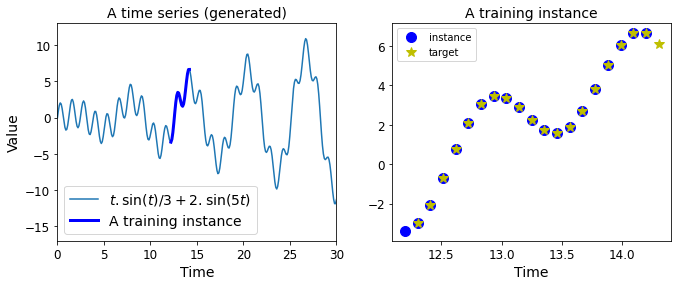

In [4]:
# The time series and the example of (x,y) are shown 

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


#save_fig("time_series_plot")
plt.show()

In [5]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('data_akbilgic.csv')
df

,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802
...,...,...,...,...,...,...,...,...,...,...
531,16-Feb-11,0.008599,0.013400,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
532,17-Feb-11,0.009310,0.015977,0.003071,-0.001186,0.000345,0.002620,0.001686,-0.000581,0.001039
533,18-Feb-11,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938
534,21-Feb-11,-0.013069,-0.013706,-0.020742,-0.014239,-0.011275,0.001358,-0.011942,-0.012615,-0.000958


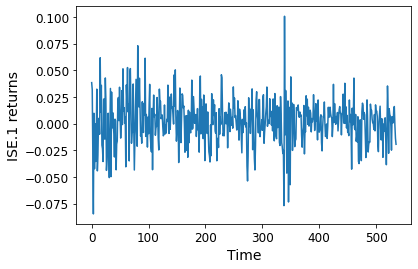

In [6]:
plt.plot(df['ISE.1'])
plt.xlabel("Time")
plt.ylabel("ISE.1 returns")
plt.show()

## Train/Test Split

Implement a train test split function without using sklearn

In [7]:
df_size = df.shape[0]
train_size = 0.8
df_train = df[:int(df_size*train_size)]
df_test = df[int(df_size*train_size):]

In [8]:
df_train, df_test

(          date       ISE     ISE.1        SP       DAX      FTSE    NIKKEI  \
 0     5-Jan-09  0.035754  0.038376 -0.004679  0.002193  0.003894  0.000000   
 1     6-Jan-09  0.025426  0.031813  0.007787  0.008455  0.012866  0.004162   
 2     7-Jan-09 -0.028862 -0.026353 -0.030469 -0.017833 -0.028735  0.017293   
 3     8-Jan-09 -0.062208 -0.084716  0.003391 -0.011726 -0.000466 -0.040061   
 4     9-Jan-09  0.009860  0.009658 -0.021533 -0.019873 -0.012710 -0.004474   
 ..         ...       ...       ...       ...       ...       ...       ...   
 423   7-Sep-10 -0.005814 -0.012223  0.000000 -0.006054 -0.005790 -0.008131   
 424   8-Sep-10 -0.002285 -0.002285  0.006418  0.007580  0.004042 -0.022071   
 425  13-Sep-10  0.026893  0.036793  0.020741  0.015651  0.024703  0.032404   
 426  14-Sep-10  0.003509  0.000956 -0.000713  0.002190  0.000341 -0.002418   
 427  15-Sep-10  0.014598  0.018699  0.003535 -0.002160 -0.002122  0.023093   
 
       BOVESPA        EU        EM  
 0    0.03119

## Batchify the Data

Below you will need to implement a fucntion that returns a a batch to feed the RNN

In [9]:
# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_stock_batch(batch_size, n_steps, df_base):
    t_min = 0
    t_max = df_base.shape[0]
  
    # The inputs will be formed by 8 sequences taken from
    # 7 time series [ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU]
    x = np.zeros((batch_size,n_steps,7))
    
    # We want to predict the returns of the Istambul stock
    # taken into consideration the previous n_steps days
    y = np.zeros((batch_size,n_steps,1))

    # We chose batch_size random points from time series x-axis

    starting_points = np.random.randint(0,t_max-n_steps-1,size=batch_size)    
    #print(starting_points)

    # We create the batches for x using all time series (8) between t and t+n_steps    
    # We create the batches for y using only one time series between t+1 and t+n_steps+1
    for k in np.arange(batch_size):
        lmat = []
        for j in np.arange(n_steps+1):
            lmat.append(df_base.iloc[starting_points[k]+j,2:].values)  
            mat = np.array(lmat)
        # The x values include all columns (mat[:n_steps,:]), these are ([ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM])
        # and TS values in mat between 0 and n_steps
        x[k,:,:] = mat[:n_steps,1:]
        
        # The y values include only column 0 (mat[1:n_steps+1,0]), this is ([ISE.1]) 
        # and TS values in mat between 1 and n_steps+1
        y[k,:,0] = mat[1:n_steps+1,0]
    
    #Save on x and y the time series data sequence and the prediction sequence

    return x,y

## Parameters
Now we need to define the parameters of our RNN

In [10]:
# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
# Since we use only a single TS, n_inputs=1
n_inputs = 7


# n_steps is the size of the contiguous sequence that is taken from the TS
# it coincides with the number of time steps for the RNN
n_steps = 10

# There is one layer of X recurrent neurons together
n_neurons = 100

# The ouput will be a single sequence
n_outputs = 1

## Architecture

In the next cell we will define our RNN architecture. For this example we will use a default torch architecture.

In [11]:
# class Model(nn.Module):
#     def __init__(self, input_size, output_size, hidden_dim, n_layers, n_steps):
#         super(Model, self).__init__()

#         # Defining some parameters
#         self.hidden_dim = hidden_dim
#         self.n_layers = n_layers
#         self.hidden = [0]
#         #Defining the layers
#         # RNN Layer
        
#         self.rnn = nn.RNN(input_size, n_outputs, n_layers, batch_first=True)   
    
#     def forward(self, x):
        
#         # complete the forward function so it returns the output and the last hidden state
#         # what is the input of an RNN?
#         if len(self.hidden) == 1:
#             #inicitialize at 0 values
#         return out, hidden
    
#     def init_hidden(self, batch_size):
#         # This method generates the first hidden state of zeros which we'll use in the forward pass
#         # We'll send the tensor holding the hidden state to the device we specified earlier as well
#         torch.zeros()
#         return hidden

class Model(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(40 * hidden_dim, 40 * hidden_dim) # 40 is the batch_size
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # print(batch_size.shape)
        # print(x.shape)
        # print(hidden.shape)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        hidden_last = hidden[-1]
        out = self.relu(hidden_last.flatten())
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        # out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)

        return out

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

## Optimizer and Loss Function

The loss functio will comput the gradients and the optimizer will apply them. In the following cell we will need to initialize our model and create the optimizer and the loss function. Select the ones that you think are most suited for the task.

In [12]:
# We initialize our RNN model to pass it to the optimizer
hidden_dim = n_steps
learning_rate = 0.01
batch_size = 40

model = Model(n_inputs, hidden_dim, n_neurons)

# What would be an adequate loss function?
# criterion = torch.nn.NNNLoss()
# criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()

# optimizer to apply the gradients
optim = Adam(model.parameters(), lr=learning_rate)



## Trainning Loop

We will define the training loop for our model. This training loop is a little different than the usual. A normal training loop is epoch based meaning that it trains for a certain ammount of epochs seeing the whole dataset in each epoch. For this model we will use an 'online' training which mean we will generate the batches the moment before feeding it with no real regard for running trhough the entire dataset.

iter:  0 	Loss:  0.11141958087682724
iter:  20 	Loss:  0.017700359225273132
iter:  40 	Loss:  0.018277382478117943
iter:  60 	Loss:  0.017977042123675346
iter:  80 	Loss:  0.017817161977291107
iter:  100 	Loss:  0.019816681742668152
iter:  120 	Loss:  0.018838059157133102
iter:  140 	Loss:  0.018254095688462257
iter:  160 	Loss:  0.0196757260710001
iter:  180 	Loss:  0.019234418869018555
iter:  200 	Loss:  0.02064976841211319
iter:  220 	Loss:  0.01925327442586422
iter:  240 	Loss:  0.01921718195080757
iter:  260 	Loss:  0.01878444291651249
iter:  280 	Loss:  0.018390998244285583
iter:  300 	Loss:  0.01961802877485752
iter:  320 	Loss:  0.01981307566165924
iter:  340 	Loss:  0.017990702763199806
iter:  360 	Loss:  0.018197491765022278
iter:  380 	Loss:  0.01729106530547142
iter:  400 	Loss:  0.01804596744477749
iter:  420 	Loss:  0.018226871266961098
iter:  440 	Loss:  0.018615659326314926
iter:  460 	Loss:  0.019029702991247177
iter:  480 	Loss:  0.019385023042559624


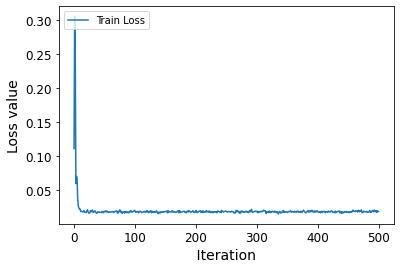

In [13]:
# #number of batches we will go through
# n_iterations = 
# #how many squence there will be in a bacth
# batch_size = 
# #after how many operations we will print information
# printing_gap = 

# #We will store the loss values here to plot them
# train_loss = []


# train_loss = []
# for iter in range(n_iterations):
#     #Get a batch

#     #make into tensor

#     #make them into torch variables in float format

#     #Reset the gradients
    
#     #Get the outputs

#     #detach the hidden state
    
#     #compute the loss

#     #compute the gradients

#     #Apply the gradients


#     #Append the loss value
#     train_loss.append()

#     if iter % printing_gap == 0:
#         #Print the information


# plt.plot(train_loss, label= "Train Loss")
# plt.xlabel(" Iteration ")
# plt.ylabel("Loss value")
# plt.legend(loc="upper left")
# plt.show()

#number of batches we will go through
n_iterations = 500
#how many squence there will be in a bacth
# batch_size = 50
#after how many operations we will print information
printing_gap = 20

#We will store the loss values here to plot them
# train_loss = []

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_loss = []
for iter in range(n_iterations):
    #Get a batch
    x_batch, y_batch = next_stock_batch(batch_size, n_steps, df_train)
    #make into tensor
    x_batch = torch.from_numpy(x_batch)
    y_batch = torch.from_numpy(y_batch).squeeze(-1)
    #make them into torch variables in float format
    x_batch = Variable(x_batch).float()
    y_batch = Variable(y_batch).float()
    #Reset the gradients
    optim.zero_grad()
    #Get the outputs
    # print(x_batch.shape)
    # print(y_batch.shape)
    output = model(x_batch) 
    #compute the loss
    loss = criterion(output, y_batch.flatten())
    #compute the gradients
    loss.backward()
    #Apply the gradients
    optim.step()

    #Append the loss value
    train_loss.append(loss.item())

    if iter % printing_gap == 0:
        #Print the information
        print('iter: ', iter, "\tLoss: ", loss.item())



plt.plot(train_loss, label= "Train Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()



## Testing

Without updating or computing the gradients test the model in a single test batch

In [17]:
#
x_test_batch, y_test_batch = next_stock_batch(batch_size, n_steps, df_test)

x_test_batch = torch.from_numpy(x_test_batch)
y_test_batch = torch.from_numpy(y_test_batch).squeeze(-1)

x_test_batch = Variable(x_test_batch).float()
y_test_batch = Variable(y_test_batch).float()
model.eval()

y_hat = model(x_test_batch)

loss_test = criterion(y_hat, y_test_batch.flatten())

loss_test



tensor(0.0150, grad_fn=<L1LossBackward>)

# Visualization

In the following cell we will plot the y_true with out prediction

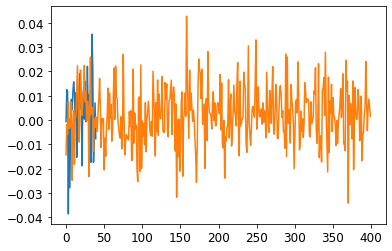

In [32]:
 #Print the ground truth sequence and the predicted sequence of a batch in train

 plt.plot(y_test_batch[:,0].numpy())
 plt.plot(y_hat.detach().numpy())

In [33]:
y_hat

tensor([-1.4320e-02, -1.7423e-03, -5.9336e-03,  7.6245e-03, -3.4393e-03,
        -3.1679e-03, -6.9744e-05,  7.3216e-03, -2.4763e-02, -3.8117e-03,
         3.8703e-03, -1.8248e-02,  1.2306e-03,  1.3434e-03,  1.1360e-02,
         2.2322e-02,  1.1444e-02, -9.0594e-03, -8.7981e-04,  2.0511e-02,
         1.2263e-02,  1.9790e-03,  7.2808e-03,  1.1196e-02,  2.2439e-02,
         7.4032e-03,  1.1511e-02, -3.4534e-04,  7.8297e-03,  5.3893e-03,
        -2.3274e-02,  8.5056e-03,  2.5867e-02,  2.2697e-03,  3.3169e-03,
         5.2555e-03, -1.2886e-02,  5.2171e-04, -3.1067e-03,  1.3208e-03,
         8.7248e-04, -4.8166e-03,  3.6517e-03,  9.0148e-03,  1.7067e-02,
         5.0261e-03, -1.1310e-02,  5.1969e-04, -1.0943e-03,  6.4078e-04,
        -2.0505e-02, -7.4572e-03, -1.4880e-02, -2.7887e-03,  2.3317e-03,
         1.3132e-02, -3.8858e-03,  1.1052e-02,  8.0521e-04,  6.4525e-03,
        -8.7005e-03, -4.9078e-03,  1.0198e-02,  2.1393e-02,  3.0423e-04,
         2.2205e-02,  9.3492e-03,  9.0209e-03,  6.4

In [34]:
y_test_batch

tensor([[-0.0007,  0.0066,  0.0003,  0.0104, -0.0069,  0.0023,  0.0128,  0.0159,
          0.0102,  0.0088],
        [ 0.0125,  0.0042,  0.0006,  0.0004, -0.0056,  0.0084, -0.0069,  0.0175,
          0.0110,  0.0118],
        [ 0.0118,  0.0069, -0.0188, -0.0263,  0.0018,  0.0091,  0.0163, -0.0047,
         -0.0154,  0.0046],
        [-0.0386, -0.0089,  0.0353,  0.0142, -0.0279,  0.0140,  0.0086,  0.0069,
         -0.0033, -0.0249],
        [ 0.0004,  0.0157, -0.0041,  0.0077, -0.0081, -0.0077, -0.0113,  0.0221,
          0.0018,  0.0085],
        [-0.0279,  0.0140,  0.0086,  0.0069, -0.0033, -0.0249,  0.0064,  0.0004,
          0.0009,  0.0134],
        [-0.0005, -0.0074,  0.0046,  0.0054, -0.0150, -0.0386, -0.0089,  0.0353,
          0.0142, -0.0279],
        [ 0.0085, -0.0064, -0.0427,  0.0144, -0.0013,  0.0070,  0.0427, -0.0044,
         -0.0057,  0.0085],
        [ 0.0042,  0.0006,  0.0004, -0.0056,  0.0084, -0.0069,  0.0175,  0.0110,
          0.0118,  0.0069],
        [ 0.0118,  

tensor(0.0006)
torch.Size([50, 30, 1])


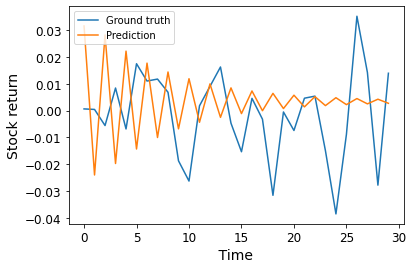

In [41]:
 #Print the ground truth sequence and the predicted sequence of a batch in test

# Extra exercises

## 1. In the previous model we used a standard RNN cell but there are better option out there try them
## 2. Add dropout and batch normalization to a more complex model using another type of cell
## 3. Create a more shopisticated model that includes at list another linear layer
## 4. Create a new trainning loop in which you validate every X batches and you save the model with better validation result
